This notebook shows the process of training a small neural network for weather forecast, optimizing the hyperparametrs and making some predictions.

First let's import some packages.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
from dataProcessing import getANSZData, DataProcessing

Let's import the data and normalize it. The iput data consists of one mounths days temperature and date (year, mounth, day) from 45 days ago. Tha date is included because it has halfed validation loss. (The data is not shuffled before slicing.) My theory is that the seasonal information is usefull for the model. The year can be also importent since the temperature is getting warmer over time. So the model can predict in 1.5 mounths in advance. The input is 30*4 values. The output is the target days temperature.

In [2]:
train_data_many_day_x, train_data_many_day_y, dev_data_many_day_x, dev_data_many_day_y, \
        test_data_many_day_x, test_data_many_day_y, rest_x = getANSZData(n_days=30, columns=['Temperature'])
pr = DataProcessing(train_data_many_day_x, train_data_many_day_y)
train_data_many_day_x = pr.preprocessInput(train_data_many_day_x)
dev_data_many_day_x = pr.preprocessInput(dev_data_many_day_x)
test_data_many_day_x = pr.preprocessInput(test_data_many_day_x)
train_data_many_day_y = pr.preprocessOutput(train_data_many_day_y)
dev_data_many_day_y = pr.preprocessOutput(dev_data_many_day_y)
test_data_many_day_y = pr.preprocessOutput(test_data_many_day_y)

The model consist of some fully connected layers. It takes advantage of early stopping, dropout (0.5) and l2 regularization. This value is determined through experiments.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from ElapsedTime import ElapsedTime

dropout = 0.5
minL2 = -8
maxL2 = 1
l2Arr = np.logspace(minL2, maxL2, -(minL2-maxL2)+1)
patience = 100
batch_size = 4096
early_stopping=EarlyStopping(patience=patience, restore_best_weights=True, verbose=1)

modelArr = []
hstArr = []
for l2 in l2Arr:
    input_size = train_data_many_day_x.shape[1]
    model = Sequential()
    model.add(Dense(units=input_size, activation='relu', input_dim=input_size, kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=input_size, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=28, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=14, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=7, activation='relu', kernel_regularizer=regularizers.l2(l2)))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mean_squared_error'])
    with ElapsedTime('training'):
        hst = model.fit(train_data_many_day_x, train_data_many_day_y, validation_data=(dev_data_many_day_x, dev_data_many_day_y),
                  verbose=0, epochs=10000, batch_size=batch_size, callbacks=[early_stopping], shuffle=True)
    hst = hst.history
    modelArr.append(model)
    hstArr.append(hst)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Restoring model weights from the end of the best epoch
Epoch 00276: early stopping
training was running for 9.399618 s
Restoring model weights from the end of the best epoch
Epoch 00331: early stopping
training was running for 8.994802 s
Restoring model weights from the end of the best epoch
Epoch 00421: early stopping
training was running for 10.179893 s
Restoring model weights from the end of the best epoch
Epoch 00554: early stopping
training was running for 13.020773 s
Restoring model weights from the end of the best epoch
Epoch 00912: early stopping
training was running for 20.223470 s
Restoring model weights from the end of the best epoch
Epoch 01581: early stopping
training was running for 33.236406 s
Restoring model weights from the end of the best epoch
Epoch 01315: early stopping
training was running for 30.250914 s
Restoring model weights from the end of the best epoch
Epoch 01680: early stopping
training was running for 38.211000 s
Restoring model weights from the end of th

Let's evaluate the models on the dev set. It seem 1e-4 is the ideal l2 value.

387/387 [==============================] - 0s 10us/step


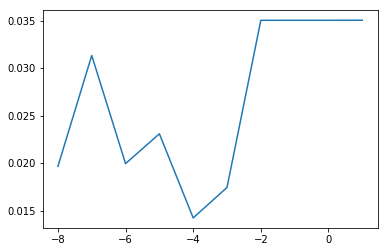

In [4]:
lossIdx = np.argwhere(map(lambda x: x == 'val_loss', model.metrics_names))[0, 0]
lossArr = []
for model in modelArr:
    metrics = model.evaluate(dev_data_many_day_x, dev_data_many_day_y, batch_size=batch_size)
    lossArr.append(metrics[lossIdx])
plt.plot(range(minL2, maxL2+1), lossArr)
plt.show()

If we plot the learning opf the optimal model, it seems that the val loss curve is under the training loss. I am nout sure aqbout the causes. Perhaps the recen weather is easier then the older.

Minimal loss is 0.0142221599817276
Minimal l2 regularization is 0.0001


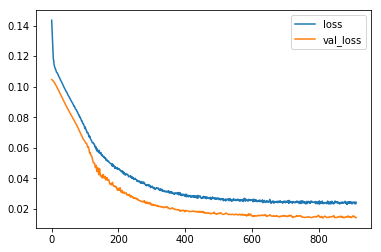

In [5]:
minLoss = np.min(lossArr)
print('Minimal loss is', minLoss)
minLossIdx = np.argmin(lossArr)
print('Minimal l2 regularization is', l2Arr[minLossIdx])
hst = hstArr[minLossIdx]
plt.plot(hst['loss'])
plt.plot(hst['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Let's save the optimal model.

In [6]:
model = modelArr[minLossIdx]
model.save('model.h5')

You can use this cell to load my training.

In [7]:
# import keras
# model = keras.models.load_model('model_original.h5')

rest_x contains the recent weather data, but we dont have yeat the associated prediction. Let's see what the future holds!

In [8]:
def predict_for_date(date):
    n_days = 30
    y_offest = 45
    first_entery_date = date - datetime.timedelta(days=n_days + y_offest) # Date of the forst input day
    # Find the temperature data index.
    idx = np.where(np.all(rest_x[:, 0:3] == \
                          [first_entery_date.year,  first_entery_date.month,  first_entery_date.day], 
                          axis=1))[0][0]
    # Make the perediction
    normalized_x = pr.preprocessInput(rest_x[idx:idx+1])
    prediction = model.predict(normalized_x)
    return pr.postProcessOutput(prediction)[0][0]

In [9]:
date_arr = [datetime.date(2018, 10, 26),
            datetime.date(2018, 11, 1),
            datetime.date(2018, 11, 29)]
for date in date_arr :
    pred = predict_for_date(date)
    print('Prediction for', date, 'is', pred, 'celsius.')

Prediction for 2018-10-26 is 12.095372 celsius.
Prediction for 2018-11-01 is 11.363732 celsius.
Prediction for 2018-11-29 is 6.9100423 celsius.
